In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

In [ ]:
def minibatch(N, M):
    """Splits data set x into M roughly equally minibatches. If not evenly divisible, the excess
    is evenly spread throughout some of the batches.

    Args:
        N (Int): Number of datapoints
        M (Int): Number of minibatches

    Returns:
        Array: [M,.]-dim array containing the minibatch indices
    """
    indices = np.random.permutation(N)  # random permutation of [0, ..., len(x)-1]
    indices = np.array_split(indices, M)  # Split permutation into M sub-arrays
    return indices

In [30]:
grid_size = 100

x = np.linspace(0,1,grid_size, dtype=np.float)
t = np.linspace(0,1,grid_size, dtype=np.float)
x, t = np.meshgrid(x, t) 
x = x.flatten()
t = t.flatten()
X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

num_points, input_dim = X.shape
hidden_neurons = 100
output_dim = 1

In [32]:
mb = minibatch(num_points, num_points / 32)

print(x[[num_points-2, num_points-1]])
print(x)

tensor([[0.9899, 1.0000],
        [1.0000, 1.0000]], grad_fn=<IndexBackward>)
tensor([[0.0000, 0.0000],
        [0.0101, 0.0000],
        [0.0202, 0.0000],
        ...,
        [0.9798, 1.0000],
        [0.9899, 1.0000],
        [1.0000, 1.0000]], requires_grad=True)


In [31]:
def g_trial(x, t, N):
    return (1 - t) * torch.sin(np.pi * x) + x * (1 - x) * t * N

#@torch.jit.script
def ode_loss(input_data, output_data):
    loss = 0
    
    for i in range(input_data.size(0)):
        Jx, Jt, Jn = jacobian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        Hx, Ht, Hn = hessian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        loss = loss + (Jt - Hx[0]).pow(2)
    
    return loss / input_data.size(0)

#ode_loss_jit = torch.jit.script(ode_loss)
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.hessian
#u_hess = hessian(g_trial, (x, N))
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.hessian
#u_jacob = jacobian(g_trial, (x, N))

#torch.autograd.set_detect_anomaly(True)

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

x = torch.from_numpy(X)
x = x.to(dtype).to(device)
x.requires_grad = True

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [33]:
EPOCHS = 10
learning_rate = 0.002
N_minibatches = int(num_points / 32)

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_neurons),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_neurons, output_dim),
        )
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model(x[mb[i]])
        # Compute and print loss
        loss = ode_loss(x[mb[i]], N_output)
        print(f"{epoch}: loss = ",loss) 
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Compute loss of entire sample
    #N_output = model(x) 
    #loss = ode_loss(x, N_output)
    #print(f"{epoch}: loss = ",loss) 
        
def g_trial_np(x, t, N):
    return (1 - t) * np.sin(np.pi * x) + x * (1 - x) * t * N

xp = np.linspace(0,1,grid_size, dtype=np.float)
tp = np.linspace(0,1,grid_size, dtype=np.float)
xp, tp = np.meshgrid(xp, xp) 

N_pred = model(x)
N_pred = N_pred.detach().numpy()
N_pred = N_pred.reshape(xp.shape)

g = g_trial_np(xp, tp, N_pred)

fig, ax = plt.subplots(figsize=(4, 3))
cf = ax.pcolormesh(xp, tp, g, cmap=plt.get_cmap("inferno"))
fig.colorbar(cf, ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

0: loss =  tensor([10.1659], grad_fn=<DivBackward0>)
1: loss =  tensor([10.0906], grad_fn=<DivBackward0>)
2: loss =  tensor([10.0250], grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [25]:
EPOCHS = 1000

for epoch in range(EPOCHS):
    mb = minibatch(num_points, N_minibatches)
    for i in range(N_minibatches):
        N_output = model(x[mb[i]])
        # Compute and print loss
        loss = ode_loss(x[mb[i]], N_output)
        # Use autograd to compute the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Compute loss of entire sample
    if epoch % 100 == 0:   
        N_output = model(x) 
        loss = ode_loss(x, N_output)
        print(f"{epoch}: loss = ",loss)    

0: loss =  tensor([0.0529], grad_fn=<DivBackward0>)
100: loss =  tensor([0.0528], grad_fn=<DivBackward0>)
200: loss =  tensor([0.0532], grad_fn=<DivBackward0>)
300: loss =  tensor([0.0516], grad_fn=<DivBackward0>)
400: loss =  tensor([0.0513], grad_fn=<DivBackward0>)
500: loss =  tensor([0.0512], grad_fn=<DivBackward0>)
600: loss =  tensor([0.0526], grad_fn=<DivBackward0>)
700: loss =  tensor([0.0501], grad_fn=<DivBackward0>)
800: loss =  tensor([0.0494], grad_fn=<DivBackward0>)
900: loss =  tensor([0.0491], grad_fn=<DivBackward0>)


<ipython-input-27-16f7f0e46d5e>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(xp, tp, g, cmap=plt.get_cmap("inferno"))


Text(0, 0.5, '$t$')

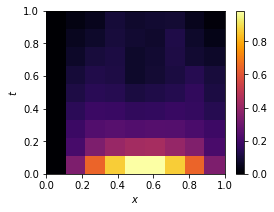

In [27]:
def g_trial_np(x, t, N):
    return (1 - t) * np.sin(np.pi * x) + x * (1 - x) * t * N

xp = np.linspace(0,1,grid_size, dtype=np.float)
tp = np.linspace(0,1,grid_size, dtype=np.float)
xp, tp = np.meshgrid(xp, xp) 

N_pred = model(x)
N_pred = N_pred.detach().numpy()
N_pred = N_pred.reshape(xp.shape)

g = g_trial_np(xp, tp, N_pred)

fig, ax = plt.subplots(figsize=(4, 3))
cf = ax.pcolormesh(xp, tp, g, cmap=plt.get_cmap("inferno"))
fig.colorbar(cf, ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

In [ ]:
def f(x, t, N):
    return (x + t - N).mean()

x_test, y_test, N_test = (x[:, 0].reshape(-1,1), x[:, 1].reshape(-1,1), N_output)
dx, dt, dN = jacobian(f, (x[:, 0].reshape(-1,1), x[:, 1].reshape(-1,1), N_output))
print(dt)

In [ ]:
dx, dt, dN = hessian(f, (x[:, 0].reshape(-1, 1), x[:, 1].reshape(-1, 1), N_output))
#print(dx[0][0])

In [ ]:
dx, dt, dN = torch.autograd.grad([f(x_test, y_test, N_test)], [x_test, y_test, N_test])

In [ ]:
x1 = torch.linspace(0,1, 10, requires_grad=True)
x2 = torch.linspace(0,1, 10, requires_grad=True)
z = torch.sin(x1) * torch.cos(x2)

print(z)
torch.autograd.grad(z, [x1, x2])